[GMM] Added .sample(n, seed) method.


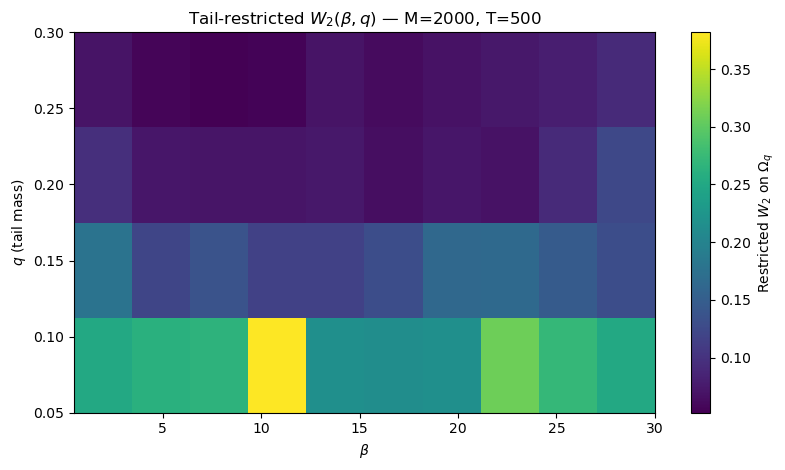

[saved] figs/restrictedW2_heatmap_M2000_T500.png


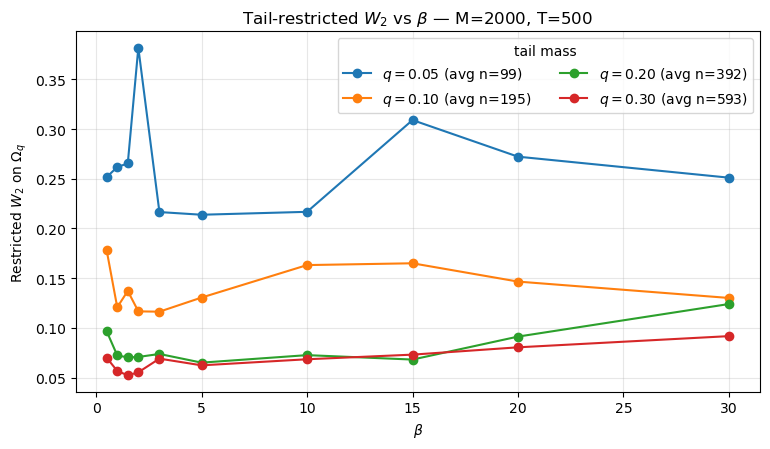

[saved] figs/restrictedW2_curves_M2000_T500.png

Restricted W2 table (rows=q, cols=beta):
           0.50     1.00     1.50     2.00     3.00     5.00    10.00    15.00    20.00    30.00
q=0.05   0.2517   0.2617   0.2654   0.3818   0.2165   0.2138   0.2167   0.3090   0.2722   0.2511
q=0.10   0.1779   0.1207   0.1371   0.1166   0.1163   0.1305   0.1631   0.1650   0.1465   0.1301
q=0.20   0.0965   0.0723   0.0703   0.0707   0.0737   0.0650   0.0726   0.0681   0.0912   0.1240
q=0.30   0.0699   0.0567   0.0522   0.0553   0.0690   0.0623   0.0684   0.0731   0.0804   0.0917

Avg selected counts per (q,β):
q=0.05: mean n_used = 99  (mean |Ω_q∩X|=104, |Ω_q∩Y|=100)
q=0.10: mean n_used = 195  (mean |Ω_q∩X|=201, |Ω_q∩Y|=200)
q=0.20: mean n_used = 392  (mean |Ω_q∩X|=398, |Ω_q∩Y|=400)
q=0.30: mean n_used = 593  (mean |Ω_q∩X|=602, |Ω_q∩Y|=600)


In [1]:
import sys
#sys.path.append('/mnt/data')
from ada_api_clean import *

# =======================================================
# Quantile-restricted W2: tails-only Wasserstein (x(0)=0)
#   Domain Ω_q = {x : p_target(x) ≤ τ_q}, with τ_q the q-quantile of p_target(Y)
#   Computes W2 between AdaPID X_β and Y restricted to Ω_q
#   Visualizes W2_restricted(β, q) as heatmap + curves
#   ENFORCES x(0)=0 in all simulations (midpoint EM)
# =======================================================
import numpy as np, math, os
import matplotlib.pyplot as plt

os.makedirs("figs", exist_ok=True)

# ---------- utilities ----------
def _logsumexp(a, axis=-1):
    a_max = np.max(a, axis=axis, keepdims=True)
    out = a_max + np.log(np.sum(np.exp(a - a_max), axis=axis, keepdims=True))
    return np.squeeze(out, axis=axis)

def gmm_logpdf(X, gmm):
    """
    Stable log pdf for isotropic GMM:
      log p(x) = log sum_k π_k N(x|μ_k, σ_k^2 I)
    """
    X = np.asarray(X, float)
    MU  = np.asarray(gmm.MU, float)         # (K,d)
    SIG = np.asarray(gmm.SIG, float)        # (K,)
    PI  = np.asarray(gmm.PI, float)         # (K,)
    K,d = MU.shape
    dx = X[:, None, :] - MU[None, :, :]     # (N,K,d)
    sq = np.sum(dx*dx, axis=2)              # (N,K)
    inv_sig2 = 1.0 / (SIG**2)               # (K,)
    log_norm = -0.5 * d * np.log(2*np.pi*(SIG**2))  # (K,)
    log_comp = (np.log(PI)[None,:] + log_norm[None,:] - 0.5 * sq * inv_sig2[None,:])
    return _logsumexp(log_comp, axis=1)     # (N,)

# ---------- simulator: midpoint EM with x(0)=0 ----------
def simulate_paths_zero_init(sched, gmm, M, T, seed, scheme="mid"):
    """
    Simulate AdaPID with midpoint drift evaluation, unit diffusion,
    and *zero initialization* X(0)=0 for all particles.
    """
    assert scheme == "mid", "Only midpoint scheme is implemented here."
    rng = np.random.default_rng(seed)
    dt  = 1.0 / T
    d   = gmm.d
    X   = np.zeros((M, d), dtype=float)  # ENFORCE x(0)=0

    for n in range(T):
        t    = (n + 0.5) / T
        yhat = yhat_oracle_gmm(X, float(t), sched, gmm)
        a_m  = float(sched.a_minus(float(t)))
        b_m  = float(sched.b_minus(float(t)))
        u    = b_m * yhat - a_m * X
        dW   = rng.normal(size=X.shape) * math.sqrt(dt)
        X    = X + u * dt + dW
    return X

def quantile_restricted_w2(X, Y, gmm, q, seed_select=None):
    """
    Compute W2 between X and Y restricted to Ω_q = { z : p_target(z) ≤ τ_q },
    where τ_q is the q-quantile of p_target on the *target sample* Y.
    Returns: (w2_restricted, n_used, nx_dom, ny_dom, tau_log)
    If insufficient points, returns (np.nan, 0, nx_dom, ny_dom, tau_log).
    """
    # threshold from target sample (sample-based tau_q)
    logpY = gmm_logpdf(Y, gmm)
    tau_log = np.quantile(logpY, q)

    # masks for a COMMON domain defined by the target pdf threshold
    logpX = gmm_logpdf(X, gmm)
    mask_Y = (logpY <= tau_log)
    mask_X = (logpX <= tau_log)

    idxY = np.nonzero(mask_Y)[0]
    idxX = np.nonzero(mask_X)[0]
    ny_dom, nx_dom = idxY.size, idxX.size
    n = min(nx_dom, ny_dom)
    if n < 3:
        return (float("nan"), 0, nx_dom, ny_dom, float(tau_log))

    # choose n points from each side uniformly within domain
    rng_sel = np.random.default_rng(seed_select)
    if nx_dom > n:
        idxX = rng_sel.choice(idxX, size=n, replace=False)
    if ny_dom > n:
        idxY = rng_sel.choice(idxY, size=n, replace=False)

    w2, _ = w2_empirical(X[idxX], Y[idxY], prefer_hungarian=True)
    return (float(w2), int(n), int(nx_dom), int(ny_dom), float(tau_log))

# ---------- experiment grid ----------
# target (use existing gmm if defined)
try:
    gmm
except NameError:
    xs = (-1.5, 0.0, 1.5)
    MU = np.array([[xi, yj] for yj in xs for xi in xs], float)
    SIG = np.full(9, 0.3)
    PI  = np.ones(9)/9
    gmm = GMM(MU, SIG, PI)

# settings
DRIFT_SCHEME = "mid"          # midpoint drift evaluation
CRN = True                    # True = same Y & simulator seed across β (smoother)
M_eval = 2000
T_eval = 500
seed_base = 314159

betas = np.array([0.5, 1.0, 1.5, 2.0, 3.0, 5.0, 10.0, 15.0, 20.0, 30.0], float)
q_list = np.array([0.05, 0.10, 0.20, 0.30], float)  # tail mass levels

# precompute Y (CRN) and cache Xβ if CRN
if CRN:
    rngY = np.random.default_rng(seed_base)
    Y_ref, _ = sample_gmm(gmm, M_eval, rngY)
    seed_sim = seed_base + 1

# simulate once per β (cache) to reuse across q — ENFORCE x(0)=0
X_cache = {}
for b in betas:
    sched = BetaSchedulePWC.constant(float(b))
    _ = alpha_K_gamma_from_schedule(sched, 0.5)
    if CRN:
        Xb = simulate_paths_zero_init(sched, gmm, M=M_eval, T=T_eval, seed=seed_sim, scheme=DRIFT_SCHEME)
    else:
        Xb = simulate_paths_zero_init(
            sched, gmm, M=M_eval, T=T_eval,
            seed=int(np.random.default_rng().integers(0, 2**32-1)),
            scheme=DRIFT_SCHEME
        )
    X_cache[float(b)] = Xb

# run grid of (q, β)
W = np.full((q_list.size, betas.size), np.nan, float)
N_used = np.zeros_like(W, int)
NXdom  = np.zeros_like(W, int)
NYdom  = np.zeros_like(W, int)

for iq, q in enumerate(q_list):
    # choose Y for this row
    if CRN:
        Y = Y_ref
        tau_seed_base = seed_base  # used for selection RNG
    else:
        Y, _ = sample_gmm(gmm, M_eval, np.random.default_rng())
        tau_seed_base = int(np.random.default_rng().integers(0, 2**32 - 1))
    for jb, b in enumerate(betas):
        X = X_cache[float(b)]
        # deterministic selection seed per cell (β,q) for reproducibility
        sel_seed = (hash((round(float(b),6), round(float(q),6), tau_seed_base)) & 0xffffffff)
        w2r, n, nx_dom, ny_dom, _tau = quantile_restricted_w2(X, Y, gmm, float(q), seed_select=sel_seed)
        W[iq, jb] = w2r
        N_used[iq, jb] = n
        NXdom[iq, jb]  = nx_dom
        NYdom[iq, jb]  = ny_dom

# ---------- visualize: heatmap ----------
plt.figure(figsize=(8.2, 4.8))
im = plt.imshow(W, origin="lower", aspect="auto",
                extent=[betas.min(), betas.max(), q_list.min(), q_list.max()])
plt.colorbar(im, label=r"Restricted $W_2$ on $\Omega_q$")
plt.xlabel(r"$\beta$")
plt.ylabel(r"$q$ (tail mass)")
plt.title(fr"Tail-restricted $W_2(\beta,q)$ — M={M_eval}, T={T_eval}")
plt.tight_layout()
fname_hm = f"figs/restrictedW2_heatmap_M{M_eval}_T{T_eval}.png"
plt.savefig(fname_hm, dpi=300, bbox_inches="tight")
plt.show()
print(f"[saved] {fname_hm}")

# ---------- visualize: curves (W2 vs β for each q) ----------
plt.figure(figsize=(7.8, 4.6))
for iq, q in enumerate(q_list):
    plt.plot(betas, W[iq], marker="o",
             label=fr"$q={q:.2f}$ (avg n={int(np.nanmean(N_used[iq]))})")
plt.xlabel(r"$\beta$")
plt.ylabel(r"Restricted $W_2$ on $\Omega_q$")
plt.title(fr"Tail-restricted $W_2$ vs $\beta$ — M={M_eval}, T={T_eval}")
plt.grid(True, alpha=0.3)
plt.legend(title="tail mass", ncol=2)
plt.tight_layout()
fname_curves = f"figs/restrictedW2_curves_M{M_eval}_T{T_eval}.png"
plt.savefig(fname_curves, dpi=300, bbox_inches="tight")
plt.show()
print(f"[saved] {fname_curves}")

# ---------- report (optional) ----------
print("\nRestricted W2 table (rows=q, cols=beta):")
hdr = "       " + " ".join([f"{b:>8.2f}" for b in betas])
print(hdr)
for iq, q in enumerate(q_list):
    row = "q={:>4.2f}".format(q) + " " + " ".join(
        [f"{W[iq,j]:8.4f}" if np.isfinite(W[iq,j]) else "   nan  " for j in range(betas.size)]
    )
    print(row)
print("\nAvg selected counts per (q,β):")
for iq, q in enumerate(q_list):
    print(f"q={q:.2f}: mean n_used = {int(np.nanmean(N_used[iq]))}  "
          f"(mean |Ω_q∩X|={int(np.nanmean(NXdom[iq]))}, |Ω_q∩Y|={int(np.nanmean(NYdom[iq]))})")


# Averaging over 10 instances with different seeds

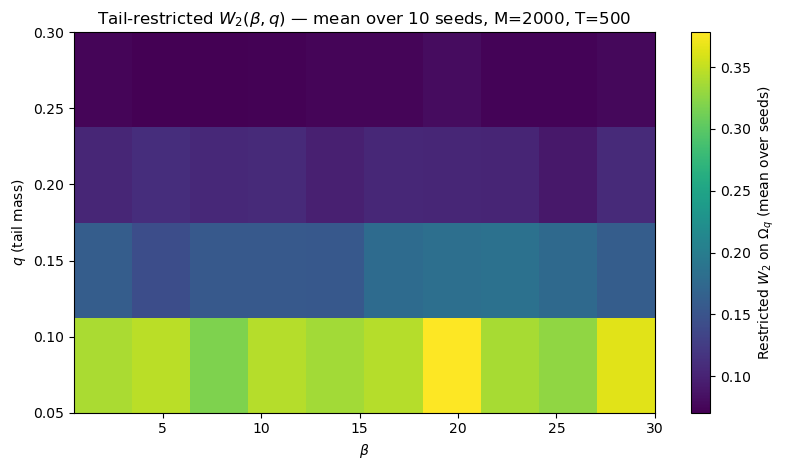

[saved] figs/restrictedW2_heatmap_mean_M2000_T500_avg.png


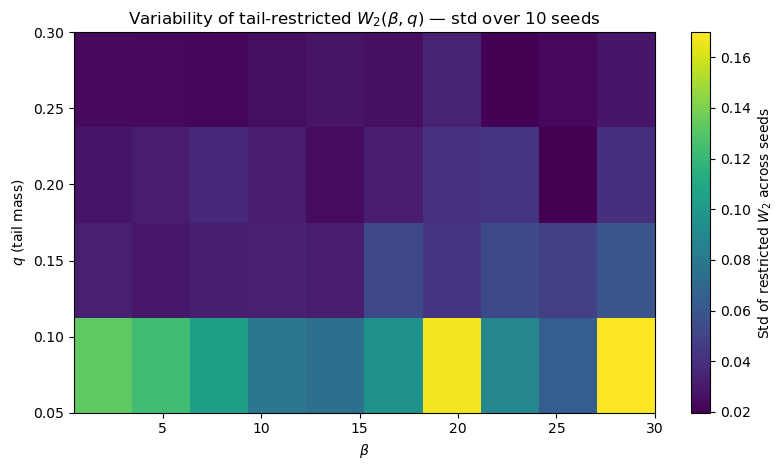

[saved] figs/restrictedW2_heatmap_std_M2000_T500_avg.png


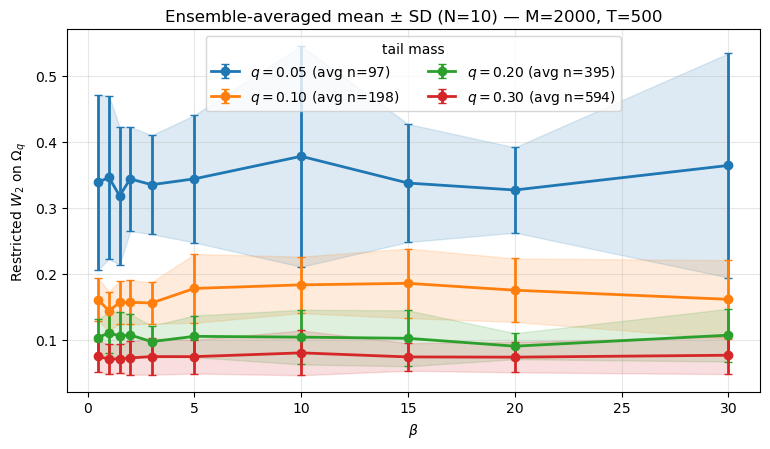

[saved] figs/restrictedW2_curves_M2000_T500_avg.png

Avg selected counts per (q, β) across seeds (n_used):
           0.50     1.00     1.50     2.00     3.00     5.00    10.00    15.00    20.00    30.00
q=0.05     97.6     98.3     98.5     98.5     99.2     97.9     97.6     98.3     95.9     97.6
q=0.10    198.7    199.0    200.0    198.6    198.8    197.9    198.4    197.4    197.6    198.2
q=0.20    396.1    396.6    393.0    395.2    392.7    397.2    397.7    395.0    396.0    398.1
q=0.30    597.1    595.8    593.4    592.7    587.4    594.1    595.7    593.1    599.0    596.2


In [4]:
# ==== NEW CELL: Ensemble-averaged mean ± SD (N=10) for quantile-restricted W2 ====
# Uses EXACTLY your previously defined computations:
#   - simulate_paths_zero_init(...)
#   - quantile_restricted_w2(...)
#   - w2_empirical(...) (used inside quantile_restricted_w2)
#   - BetaSchedulePWC, alpha_K_gamma_from_schedule, yhat_oracle_gmm, GMM, etc.
# And reuses your existing variables: gmm, betas, q_list, M_eval, T_eval, DRIFT_SCHEME, seed_base, CRN
#
# Outputs:
#   figs/restrictedW2_heatmap_mean_M{M_eval}_T{T_eval}_avg.png
#   figs/restrictedW2_heatmap_std_M{M_eval}_T{T_eval}_avg.png
#   figs/restrictedW2_curves_M{M_eval}_T{T_eval}_avg.png

import numpy as np
import matplotlib.pyplot as plt
import os, math

os.makedirs("figs", exist_ok=True)

# --- repetitions ---
N_REP = 10
# large offsets to ensure independence across repetitions while keeping structure
OFF_SIM  = 1_000_000
OFF_TAU  = 2_000_000

# storage: list of W matrices (each shape = (len(q_list), len(betas)))
W_reps = []
N_used_reps = []   # optional, to summarize selected counts
NXdom_reps  = []
NYdom_reps  = []

for rep in range(N_REP):
    # base seeds for this repetition (mirror your CRN logic)
    rep_seed_base = seed_base + rep * OFF_SIM
    rep_tau_base  = seed_base + rep * OFF_TAU  # for selection/reproducibility

    # --- (re)build caches per repetition using EXACTLY your logic ---
    if CRN:
        rngY = np.random.default_rng(rep_seed_base)
        Y_ref, _ = sample_gmm(gmm, M_eval, rngY)
        seed_sim = rep_seed_base + 1
    # simulate once per beta, cache Xβ
    X_cache = {}
    for b in betas:
        sched = BetaSchedulePWC.constant(float(b))
        _ = alpha_K_gamma_from_schedule(sched, 0.5)  # interior sanity as in your code
        if CRN:
            Xb = simulate_paths_zero_init(sched, gmm, M=M_eval, T=T_eval, seed=seed_sim, scheme=DRIFT_SCHEME)
        else:
            # independent seed each time (same as your else-branch)
            Xb = simulate_paths_zero_init(
                sched, gmm, M=M_eval, T=T_eval,
                seed=int(np.random.default_rng().integers(0, 2**32 - 1)),
                scheme=DRIFT_SCHEME
            )
        X_cache[float(b)] = Xb

    # run the (q, beta) grid for this repetition
    W   = np.full((q_list.size, betas.size), np.nan, float)
    Nus = np.zeros_like(W, int)
    NXd = np.zeros_like(W, int)
    NYd = np.zeros_like(W, int)

    for iq, q in enumerate(q_list):
        # choose Y for this row, exactly as in your cell
        if CRN:
            Y = Y_ref
            tau_seed_base = rep_seed_base
        else:
            Y, _ = sample_gmm(gmm, M_eval, np.random.default_rng())
            tau_seed_base = int(np.random.default_rng().integers(0, 2**32 - 1))

        for jb, b in enumerate(betas):
            X = X_cache[float(b)]
            sel_seed = (hash((round(float(b),6), round(float(q),6), tau_seed_base)) & 0xffffffff)
            w2r, n, nx_dom, ny_dom, _tau = quantile_restricted_w2(X, Y, gmm, float(q), seed_select=sel_seed)
            W[iq, jb]   = w2r
            Nus[iq, jb] = n
            NXd[iq, jb] = nx_dom
            NYd[iq, jb] = ny_dom

    W_reps.append(W)
    N_used_reps.append(Nus)
    NXdom_reps.append(NXd)
    NYdom_reps.append(NYd)

# --- aggregate across repetitions (mean ± SD) ---
W_reps_arr   = np.stack(W_reps, axis=0)          # (N_REP, |q|, |beta|)
W_mean       = np.nanmean(W_reps_arr, axis=0)
W_std        = np.nanstd(W_reps_arr,  axis=0, ddof=0)

N_used_mean  = np.mean(np.stack(N_used_reps, axis=0), axis=0)
NXdom_mean   = np.mean(np.stack(NXdom_reps,  axis=0), axis=0)
NYdom_mean   = np.mean(np.stack(NYdom_reps,  axis=0), axis=0)

# --- heatmap of mean ---
plt.figure(figsize=(8.2, 4.8))
im = plt.imshow(W_mean, origin="lower", aspect="auto",
                extent=[betas.min(), betas.max(), q_list.min(), q_list.max()])
plt.colorbar(im, label=r"Restricted $W_2$ on $\Omega_q$ (mean over seeds)")
plt.xlabel(r"$\beta$")
plt.ylabel(r"$q$ (tail mass)")
plt.title(fr"Tail-restricted $W_2(\beta,q)$ — mean over {N_REP} seeds, M={M_eval}, T={T_eval}")
plt.tight_layout()
fname_hm_mean = f"figs/restrictedW2_heatmap_mean_M{M_eval}_T{T_eval}_avg.png"
plt.savefig(fname_hm_mean, dpi=300, bbox_inches="tight")
plt.show()
print(f"[saved] {fname_hm_mean}")

# --- heatmap of std (variability) ---
plt.figure(figsize=(8.2, 4.8))
im = plt.imshow(W_std, origin="lower", aspect="auto",
                extent=[betas.min(), betas.max(), q_list.min(), q_list.max()])
plt.colorbar(im, label=r"Std of restricted $W_2$ across seeds")
plt.xlabel(r"$\beta$")
plt.ylabel(r"$q$ (tail mass)")
plt.title(fr"Variability of tail-restricted $W_2(\beta,q)$ — std over {N_REP} seeds")
plt.tight_layout()
fname_hm_std = f"figs/restrictedW2_heatmap_std_M{M_eval}_T{T_eval}_avg.png"
plt.savefig(fname_hm_std, dpi=300, bbox_inches="tight")
plt.show()
print(f"[saved] {fname_hm_std}")

# --- curves per q: mean ± SD (ribbons + error bars) ---
plt.figure(figsize=(7.8, 4.6))
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for iq, q in enumerate(q_list):
    mean_q = W_mean[iq]
    std_q  = W_std[iq]
    # ribbon
    plt.fill_between(betas, mean_q - std_q, mean_q + std_q, alpha=0.15, color=colors[iq % len(colors)])
    # mean + error bars
    plt.errorbar(betas, mean_q, yerr=std_q, fmt="-o", lw=2.0, capsize=3,
                 label=fr"$q={q:.2f}$ (avg n={int(np.nanmean(N_used_mean[iq]))})",
                 color=colors[iq % len(colors)])
plt.xlabel(r"$\beta$")
plt.ylabel(r"Restricted $W_2$ on $\Omega_q$")
plt.title(fr"Ensemble-averaged mean ± SD (N={N_REP}) — M={M_eval}, T={T_eval}")
plt.grid(True, alpha=0.3)
plt.legend(title="tail mass", ncol=2)
plt.tight_layout()
fname_curves_avg = f"figs/restrictedW2_curves_M{M_eval}_T{T_eval}_avg.png"
plt.savefig(fname_curves_avg, dpi=300, bbox_inches="tight")
plt.show()
print(f"[saved] {fname_curves_avg}")

# --- optional: brief report of average selected counts across seeds ---
print("\nAvg selected counts per (q, β) across seeds (n_used):")
hdr = "       " + " ".join([f"{b:>8.2f}" for b in betas])
print(hdr)
for iq, q in enumerate(q_list):
    row = "q={:>4.2f}".format(q) + " " + " ".join([f"{N_used_mean[iq,j]:8.1f}" for j in range(betas.size)])
    print(row)


# The same -- but only the last figure -- in three panels for three GMM models

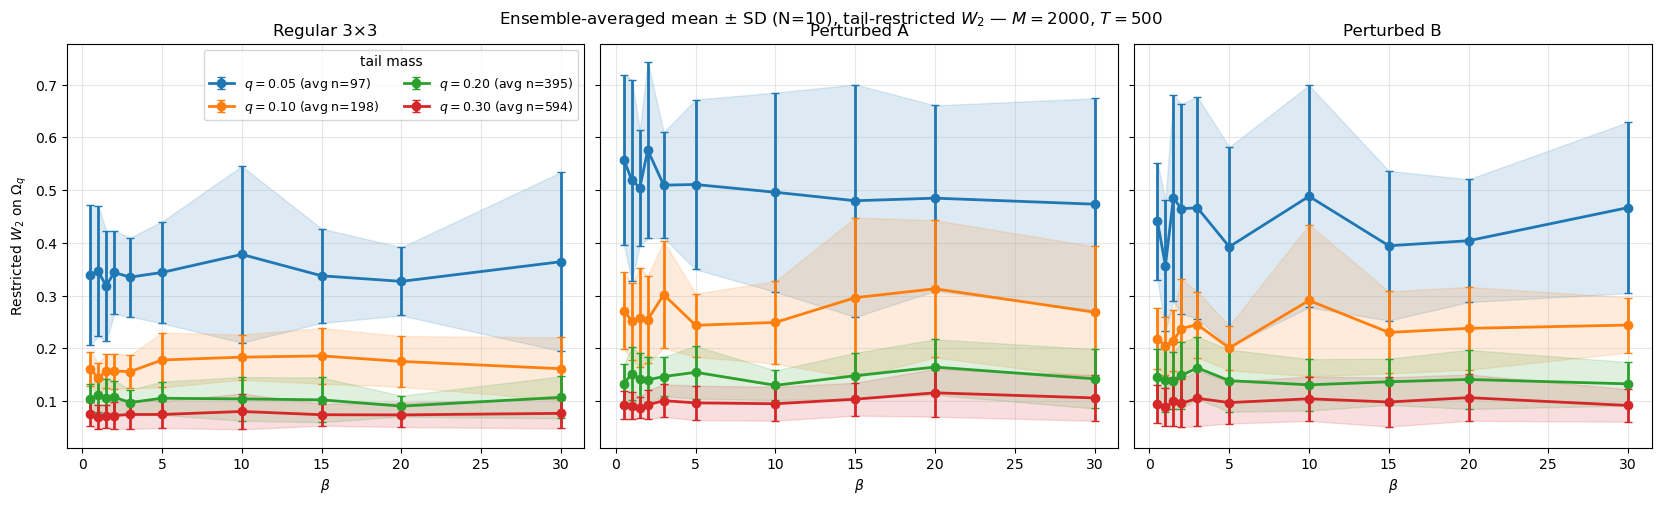

[saved] figs/restrictedW2_curves_M2000_T500_avg-3models.png


In [5]:
# ==== NEW CELL: Ensemble-averaged mean ± SD (N=10) for quantile-restricted W2 ====
# Now for three models
# Uses EXACTLY your previously defined computations:
#   - simulate_paths_zero_init(...)
#   - quantile_restricted_w2(...)
#   - w2_empirical(...) (used inside quantile_restricted_w2)
#   - BetaSchedulePWC, alpha_K_gamma_from_schedule, yhat_oracle_gmm, GMM, etc.
# And reuses your existing variables: gmm, betas, q_list, M_eval, T_eval, DRIFT_SCHEME, seed_base, CRN
#
# Output:
#   figs/restrictedW2_curves_M{M_eval}_T{T_eval}_avg-3models.png

import numpy as np
import matplotlib.pyplot as plt
import os, math

os.makedirs("figs", exist_ok=True)

# setting up gmm list
MODEL_TUPLES = [
    ("Regular 3×3", regular),
    ("Perturbed A",  pertA),
    ("Perturbed B",  pertB),
]

# --- repetitions ---
N_REP = 10
# large offsets to ensure independence across repetitions while keeping structure
OFF_SIM  = 1_000_000
OFF_TAU  = 2_000_000

def _aggregate_for_model(gmm_obj):
    """Run your exact quantile-restricted W2 computation N_REP times for a given model (gmm_obj),
    and return (W_mean, W_std, N_used_mean). DOES NOT change any math—only repeats with seed offsets."""
    # temporarily set the global gmm so all your existing functions use it
    global gmm
    gmm_backup = gmm
    gmm = gmm_obj

    W_reps = []
    N_used_reps = []

    for rep in range(N_REP):
        # base seeds for this repetition (mirror your CRN logic with offsets)
        rep_seed_base = seed_base + rep * OFF_SIM
        rep_tau_base  = seed_base + rep * OFF_TAU  # for selection/reproducibility

        # --- (re)build caches per repetition using EXACTLY your logic ---
        if CRN:
            rngY = np.random.default_rng(rep_seed_base)
            Y_ref, _ = sample_gmm(gmm, M_eval, rngY)
            seed_sim = rep_seed_base + 1

        # simulate once per beta, cache Xβ
        X_cache = {}
        for b in betas:
            sched = BetaSchedulePWC.constant(float(b))
            _ = alpha_K_gamma_from_schedule(sched, 0.5)
            if CRN:
                Xb = simulate_paths_zero_init(sched, gmm, M=M_eval, T=T_eval, seed=seed_sim, scheme=DRIFT_SCHEME)
            else:
                Xb = simulate_paths_zero_init(
                    sched, gmm, M=M_eval, T=T_eval,
                    seed=int(np.random.default_rng().integers(0, 2**32 - 1)),
                    scheme=DRIFT_SCHEME
                )
            X_cache[float(b)] = Xb

        # run the (q, beta) grid for this repetition
        W   = np.full((q_list.size, betas.size), np.nan, float)
        Nus = np.zeros_like(W, int)

        for iq, q in enumerate(q_list):
            # choose Y for this row, exactly as in your cell
            if CRN:
                Y = Y_ref
                tau_seed_base = rep_seed_base
            else:
                Y, _ = sample_gmm(gmm, M_eval, np.random.default_rng())
                tau_seed_base = int(np.random.default_rng().integers(0, 2**32 - 1))

            for jb, b in enumerate(betas):
                X = X_cache[float(b)]
                sel_seed = (hash((round(float(b),6), round(float(q),6), tau_seed_base)) & 0xffffffff)
                w2r, n, _, _, _ = quantile_restricted_w2(X, Y, gmm, float(q), seed_select=sel_seed)
                W[iq, jb]   = w2r
                Nus[iq, jb] = n

        W_reps.append(W)
        N_used_reps.append(Nus)

    # aggregate
    W_reps_arr  = np.stack(W_reps, axis=0)          # (N_REP, |q|, |beta|)
    W_mean      = np.nanmean(W_reps_arr, axis=0)
    W_std       = np.nanstd(W_reps_arr,  axis=0, ddof=0)
    N_used_mean = np.mean(np.stack(N_used_reps, axis=0), axis=0)

    # restore original gmm
    gmm = gmm_backup
    return W_mean, W_std, N_used_mean

# --- compute aggregates for each model ---
agg_by_model = {}
for name, gmm_obj in MODEL_TUPLES:
    agg_by_model[name] = _aggregate_for_model(gmm_obj)

# --- plot three panels: curves per q with mean ± SD (ribbons + error bars) ---
fig, axs = plt.subplots(1, 3, figsize=(16.5, 4.8), constrained_layout=True, sharey=True)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for ax, (name, _) in zip(axs, MODEL_TUPLES):
    W_mean, W_std, N_used_mean = agg_by_model[name]
    for iq, q in enumerate(q_list):
        mean_q = W_mean[iq]
        std_q  = W_std[iq]
        # ribbon
        ax.fill_between(betas, mean_q - std_q, mean_q + std_q, alpha=0.15, color=colors[iq % len(colors)])
        # mean + error bars
        ax.errorbar(betas, mean_q, yerr=std_q, fmt="-o", lw=2.0, capsize=3,
                    label=fr"$q={q:.2f}$ (avg n={int(np.nanmean(N_used_mean[iq]))})",
                    color=colors[iq % len(colors)])
    ax.set_title(name)
    ax.set_xlabel(r"$\beta$")
    ax.grid(True, alpha=0.3)

axs[0].set_ylabel(r"Restricted $W_2$ on $\Omega_q$")
axs[0].legend(title="tail mass", ncol=2, frameon=True, fontsize=9, loc="upper right")

fig.suptitle(fr"Ensemble-averaged mean ± SD (N={N_REP}), tail-restricted $W_2$ — $M={M_eval}$, $T={T_eval}$", y=1.02, fontsize=12)

out_3panel = f"figs/restrictedW2_curves_M{M_eval}_T{T_eval}_avg-3models.png"
fig.savefig(out_3panel, dpi=300, bbox_inches="tight")
plt.show()
print(f"[saved] {out_3panel}")
